In this notebook I will try and predict what kind of an incident occured based on where it took place and how long it took to resolve. 

Target: issue_reported(y)
Input vairables: Latitude, Longitude, timespan_min(x)


In [151]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,log_loss, f1_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

Import data of clean features

In [152]:
file = 'traffic_data_features.csv'

In [153]:
df = pd.read_csv(file, index_col=False)
df.head()

,issue_reported,Latitude,Longitude,day,timespan_min,hour,month
0,Crash Service,30.283797,-97.741906,2,144.066667,6,6
1,Traffic Hazard,30.339593,-97.700963,2,64.450000,10,6
2,Crash Service,30.329455,-97.638105,4,30.000000,21,4
3,Traffic Hazard,30.202806,-97.760701,4,14.183333,21,4
4,Crash Service,30.184265,-97.687339,4,149.150000,21,4


In [154]:
df.describe()

,Latitude,Longitude,day,timespan_min,hour,month
count,225445.000000,225445.000000,225445.000000,225445.000000,225445.000000,225445.000000
mean,30.301440,-97.733156,2.906261,49.665617,13.693637,6.980594
std,0.094080,0.087511,1.935056,39.684226,7.140035,3.388540
min,30.003883,-98.226709,0.000000,0.333333,0.000000,1.000000
25%,30.231715,-97.777183,1.000000,19.500000,9.000000,4.000000
50%,30.293602,-97.734450,3.000000,37.500000,15.000000,7.000000
75%,30.373691,-97.686922,5.000000,68.516667,20.000000,10.000000
max,30.798642,-97.293320,6.000000,200.000000,23.000000,12.000000


In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225445 entries, 0 to 225444
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   issue_reported  225445 non-null  object 
 1   Latitude        225445 non-null  float64
 2   Longitude       225445 non-null  float64
 3   day             225445 non-null  int64  
 4   timespan_min    225445 non-null  float64
 5   hour            225445 non-null  int64  
 6   month           225445 non-null  int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 12.0+ MB


#  Use Label Encoder to Create Dummy Values
Because I am trying to predict the issue reported I will transform the column using LabelEncoder(). Then a quick check to ensure the numbers line up like before.

In [156]:
le = LabelEncoder()
df['issue_reported']=le.fit_transform(df['issue_reported'])
df.head()

,issue_reported,Latitude,Longitude,day,timespan_min,hour,month
0,2,30.283797,-97.741906,2,144.066667,6,6
1,5,30.339593,-97.700963,2,64.450000,10,6
2,2,30.329455,-97.638105,4,30.000000,21,4
3,5,30.202806,-97.760701,4,14.183333,21,4
4,2,30.184265,-97.687339,4,149.150000,21,4


In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225445 entries, 0 to 225444
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   issue_reported  225445 non-null  int64  
 1   Latitude        225445 non-null  float64
 2   Longitude       225445 non-null  float64
 3   day             225445 non-null  int64  
 4   timespan_min    225445 non-null  float64
 5   hour            225445 non-null  int64  
 6   month           225445 non-null  int64  
dtypes: float64(3), int64(4)
memory usage: 12.0 MB


In [158]:
df['issue_reported'].unique()

array([2, 5, 1, 4, 0, 3, 6])

In [159]:
df['issue_reported'].value_counts()

5    92530
2    85024
0    25467
4    10818
3     5567
1     5286
6      753
Name: issue_reported, dtype: int64

In [160]:
avg_issue = df.groupby('issue_reported').mean()
avg_issue_span = avg_issue.timespan_min
avg_issue_span

issue_reported
0    42.979385
1    55.196339
2    68.461010
3    42.089731
4    31.433333
5    36.540976
6    45.440106
Name: timespan_min, dtype: float64

In [161]:
median_issue = df.groupby('issue_reported').median()
median_issue_span = median_issue.timespan_min
median_issue_span

issue_reported
0    36.016667
1    50.450000
2    60.466667
3    32.066667
4    22.775000
5    27.000000
6    31.833333
Name: timespan_min, dtype: float64

## Creating Location Categories

I have used local landmarks to divide the city up into 12 pieces. This will help establish if there is a correlation between and issue reported and the are of town where it ocurrs.

Location definitions
vnw = The very northwest edge of the city that is west of I35 and north of 183
vcw = West of MOPAC but south of 183 and north of 290
vsw = The very southwest edge of the city that is west of I35 and south of Ben White

cnw = Central northwest of the city, west of I35, south of 183, east of MOPAC, north of MLK
cw = Central west of the city, west of I35, south of MLK, east of MOPAC, north of the river
csw = Central southwest of the city, west of I35, south of the river, east of MOPAC, north of Ben White

cne = Central northeast of the city, east of I35, South of 183, east of 183 and north of MLK
ce = Central east of the city, east of I35, south of MLK, east of 183, north of the river
cse = Central southeast of the city, east of I35, south of the river, east of 183, north of Ben White

vne = The very northeast edge of the city that is east of I35, east and north of 183
vce = The very east of the city, east 183, south of 290(east), north of Ben White/71
vse = The very southeast of the city, east of I35, south of Ben White/71

other = a coordinate not within a field

![](AustinGrid.jpg)

![](AustinGrid.jpg)

In [162]:
def partOfCity(lat, lon):
    if (lat <= 30.21638 and lon < -97.72575):
        return "vsw"
    elif (lat <= 30.21638 and lon >= -97.72575):
        return "vse"
    
    elif (lat > 30.33926 and lon < -97.72575):
        return "vnw"
    elif (lat >= 30.33926 and lon >= -97.72575):
        return "vne"
    
    elif (lat >= 30.21638 and lat < 30.33926 and lon < -97.75816):
        return "vcw"
    elif (lat >= 30.21638 and lat <= 30.33926 and lon >= -97.66523):
        return "vce"
    #inner grid
    elif (lat < 30.25108 and lat >= 30.21638 and lon < -97.72575 and lon > -97.75816):
        return "csw"
    elif (lat < 30.25108 and lat >= 30.21638 and lon >= -97.72575 and lon < -97.66523):
        return "cse"
    
    elif (lat < 30.33926 and lat > 30.27887 and lon > -97.72575 and lon < -97.66523):
        return "cne"
    elif (lat <= 30.33926 and lat > 30.27887 and lon <= -97.72575 and lon > -97.75816):
        return "cnw"
    
    elif(lat >= 30.25108 and lat <= 30.27887 and lon >= -97.72575 and lon <= -97.66523):
        return "ce"
    elif(lat > 30.25108 and lat < 30.27887 and lon < -97.72575 and lon > -97.75816):
        return "cw"
    else:
        return "other"

# New Feature for "Latitude" and "Longitude" Called "Region"
I want to create a new column called "region" and use the above fuction to divide up incidents into one of 12 areas.

In [163]:
df['region'] = df.apply(lambda x: partOfCity(x['Latitude'], x['Longitude']), axis=1)

In [164]:
df.head()

,issue_reported,Latitude,Longitude,day,timespan_min,hour,month,region
0,2,30.283797,-97.741906,2,144.066667,6,6,cnw
1,5,30.339593,-97.700963,2,64.450000,10,6,vne
2,2,30.329455,-97.638105,4,30.000000,21,4,vce
3,5,30.202806,-97.760701,4,14.183333,21,4,vsw
4,2,30.184265,-97.687339,4,149.150000,21,4,vse


In [165]:
df['region'].value_counts()

vne    46522
vnw    34619
vcw    29815
vsw    28881
cne    16911
vse    13828
cw     13356
vce    13000
cnw     9623
csw     7660
cse     6366
ce      4864
Name: region, dtype: int64

### A visualization for "Region" distribution

<AxesSubplot:>

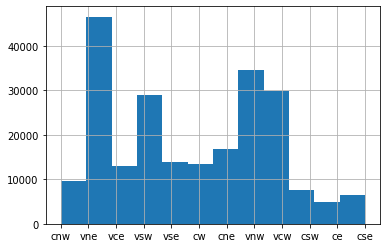

In [166]:
df.region.hist(bins=12)

## Apply LabelEncoder on the new categorical column 'region'.

In [167]:
le2 = LabelEncoder()
df['region']=le2.fit_transform(df['region'])
df.head()

,issue_reported,Latitude,Longitude,day,timespan_min,hour,month,region
0,2,30.283797,-97.741906,2,144.066667,6,6,2
1,5,30.339593,-97.700963,2,64.450000,10,6,8
2,2,30.329455,-97.638105,4,30.000000,21,4,6
3,5,30.202806,-97.760701,4,14.183333,21,4,11
4,2,30.184265,-97.687339,4,149.150000,21,4,10


### Drop "Latitude" and "Longitude"

In [168]:
df = df.drop(columns=['Latitude', 'Longitude'])
df.head()

,issue_reported,day,timespan_min,hour,month,region
0,2,2,144.066667,6,6,2
1,5,2,64.450000,10,6,8
2,2,4,30.000000,21,4,6
3,5,4,14.183333,21,4,11
4,2,4,149.150000,21,4,10


## One Hot Encoding for the four other features

In [169]:
dummies = pd.get_dummies(df, columns=['day','hour','month','region'])

In [170]:
X = dummies.drop(columns='issue_reported')

In [171]:

y = df.issue_reported

In [172]:
X.shape

(225445, 56)

In [173]:
y.shape

(225445,)

## Train Test Split and Scale

In [174]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=123)

In [175]:
scaler = StandardScaler()

In [176]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Running Default Models and Comparing Algorithms
X and y are set so all models can be fit through these two variables. I will fit three models and see which is most accurate. The four models will be KNN, Random Forest and Decision Tree.

In [179]:
models = []

models.append(('RFC', RandomForestClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier(max_depth = 2)))

In [180]:
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=5, random_state=None)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

RFC: 0.457256 (0.009420)
KNN: 0.467014 (0.008891)
DTC: 0.536082 (0.016017)


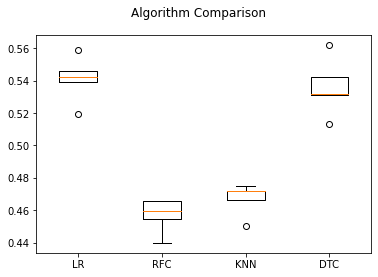

In [57]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [122]:
model =  xgb.XGBClassifier()

In [123]:
model.fit(X_train, y_train)

/Users/tshields/opt/anaconda3/envs/Springboard/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:36:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [124]:
model.score(X_train, y_train)

0.5723495013565763

In [125]:
model.score(X_test, y_test)

0.5468961387478098

In [101]:
prediction=model.predict(X_test)

/Users/tshields/opt/anaconda3/envs/Springboard/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='issue_reported', ylabel='Density'>

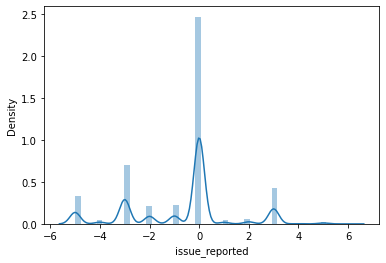

In [102]:
sns.distplot(y_test-prediction)